# **Build A Real-World Flower Classifier of 102 Flower Types**

## **Author: Saurabh Bhardwaj**
## Last Updated: 05 Jan 2022

## Introduction
This Jupyter Notebook shows step-by-step guide on:

- Download the 102 flower dataset. I've used the 102 Category Flower Dataset from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

- Data visualisation of few categories of the flower dataset

- Using Transfer Learning for feature extraction from a pre-trained model Resnet 50.

- Using PyTorch apply Data Augementation to the data and build input pipelines for the dataset split into training, validation and test datasets.

- Build, train and evaluate the model.

- Using Callback to define early stopping threshold for model training.

- Report Model accuracy

- Make prediction with the trained model

- Save Model




# Install the required Python packages from the command below.


In [55]:
import os,json

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision.models import resnet50, ResNet50_Weights
%matplotlib inline

In [2]:
# Project name used for jovian.commit
project_name = '04-torch-flower-classification'

## Downloading the Dataset

I've used the 102 Category Flower Dataset from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html consisting of 102 flower categories 

In [3]:
# !wget https://raw.githubusercontent.com/nirajpandkar/flowers-classification-pytorch/master/cat_to_name.json
# !wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
# !mkdir data && tar -xvf flower_data.tar.gz -C data

# Set up the device 

In [4]:
# Set device to GPU if available else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The current deivce is {device}')

The current deivce is cuda


## Creating a Custom PyTorch Dataset

In [5]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
img_size = 256
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [7]:
# applu data augmentation
training_transforms = T.Compose([
    T.Pad(8, padding_mode='reflect'),
    T.RandomRotation(30),
    T.RandomResizedCrop(img_size),
    T.RandomHorizontalFlip(),
    T.ToTensor(), # For GPU purpose
    # As we are going to do transfer learning with a ImageNet pretrained VGG
    # so here we normalize the dataset being used here with the ImageNet stats
    # for better transfer learning performance
    T.Normalize(*imagenet_stats)
])

validation_transforms = T.Compose([
    T.Pad(8, padding_mode='reflect'),
    T.Resize(256),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

testing_transforms = T.Compose([
    T.Pad(8, padding_mode='reflect'),
    T.Resize(256),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

# Load the datasets with torchvision.datasets.ImageFolder object
training_imagefolder = ImageFolder(train_dir, transform = training_transforms)
validation_imagefolder = ImageFolder(valid_dir, transform = validation_transforms)
testing_imagefolder = ImageFolder(test_dir, transform = testing_transforms)

## Creating Training, Validation and Test Sets

In [8]:
batch_size = 64

# Define the torch.utils.data.DataLoader() object with the ImageFolder object
# Dataloader is a generator to read from ImageFolder and generate them into batch-by-batch
# Only shuffle during trianing, validation and testing no shuffles
# the batchsize for training and tesitng no need to be the same
train_loader = DataLoader(training_imagefolder, batch_size = batch_size, shuffle = True)
validate_loader = DataLoader(validation_imagefolder, batch_size = batch_size)
test_loader = DataLoader(testing_imagefolder, batch_size = batch_size)

## Exploratory Analysis

In [9]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

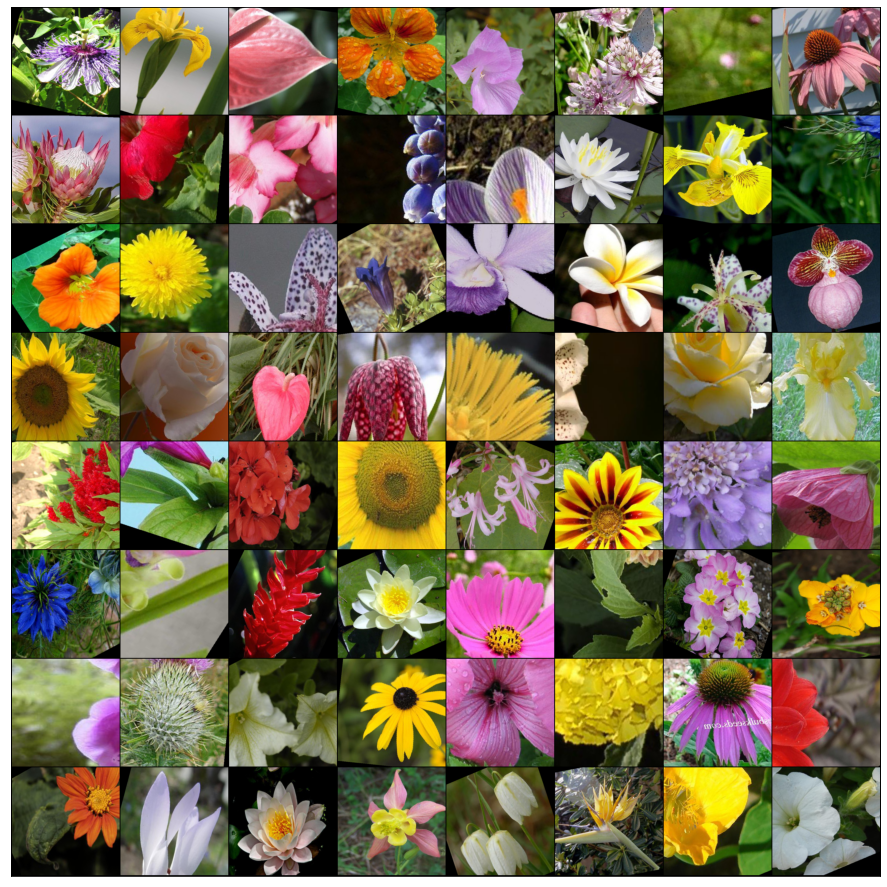

In [10]:
show_batch(train_loader)

In [11]:
def show_example(img, label, dataset):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0));

Label:  1 (0)


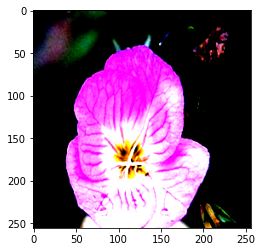

In [12]:
img, label = training_imagefolder[0]
show_example(img, label,training_imagefolder)

Label:  10 (1)


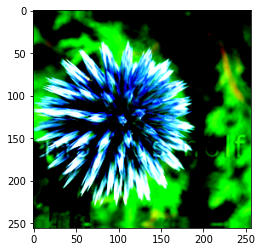

In [13]:
show_example(*validation_imagefolder[10],validation_imagefolder)

## Custom Pytorch Model

In [18]:
class FlowersModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Use a pretrained model
        self.network = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

    def training_step(self, images, labels):
        pred = self(images)                   # Generate predictions
        loss = F.cross_entropy(pred, labels)  # Calculate loss
        return loss

Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops.

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
# function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# evaluate function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    results = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        result = {'val_loss': loss.detach(), 'val_acc': acc}
        results.append(result)

    batch_losses = [loss['val_loss'] for loss in results]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [acc['val_acc'] for acc in results]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

# training function
def fit(epochs, lr, model, train_loader, val_loader, early_stop = False, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step(images, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
        history.append(result)
        if early_stop:
            if early_stopper.early_stop(result['val_loss']):             
                break

    return history
#get the lr from the scheduler
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# training with weight decay
def fit_with_decay(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            loss = model.training_step(images, labels)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
        history.append(result)
    return history

In [21]:
# Define Model and transfer it to the device
model = FlowersModel(len(training_imagefolder.classes)).to(device)

In [22]:
history = [evaluate(model, validate_loader)]
history

[{'val_loss': 4.645122051239014, 'val_acc': 0.0012019231216982007}]

In [23]:
# hyperparameters
epochs = 20
lr = 0.001
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history = fit(epochs, lr, model, train_loader, validate_loader, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 1.8163, val_loss: 0.7197, val_acc: 0.7981
Epoch [1], train_loss: 0.6336, val_loss: 0.5252, val_acc: 0.8579
Epoch [2], train_loss: 0.4828, val_loss: 0.5665, val_acc: 0.8459
Epoch [3], train_loss: 0.3691, val_loss: 0.3391, val_acc: 0.9276
Epoch [4], train_loss: 0.3418, val_loss: 0.3607, val_acc: 0.9166
Epoch [5], train_loss: 0.2800, val_loss: 0.2546, val_acc: 0.9420
Epoch [6], train_loss: 0.2789, val_loss: 0.2766, val_acc: 0.9356
Epoch [7], train_loss: 0.2715, val_loss: 0.2461, val_acc: 0.9303
Epoch [8], train_loss: 0.2395, val_loss: 0.2332, val_acc: 0.9365
Epoch [9], train_loss: 0.2483, val_loss: 0.3378, val_acc: 0.9114
Epoch [10], train_loss: 0.2105, val_loss: 0.3057, val_acc: 0.9195
Epoch [11], train_loss: 0.2172, val_loss: 0.1764, val_acc: 0.9585
Epoch [12], train_loss: 0.1915, val_loss: 0.2315, val_acc: 0.9418
Epoch [13], train_loss: 0.1940, val_loss: 0.3003, val_acc: 0.9238
Epoch [14], train_loss: 0.1672, val_loss: 0.1888, val_acc: 0.9554
Epoch [15], train_lo

In [25]:
%%time
history_stop = fit(epochs, lr, model, train_loader, validate_loader, early_stop = True, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.2154, val_loss: 0.3246, val_acc: 0.9289
Epoch [1], train_loss: 0.1778, val_loss: 0.2484, val_acc: 0.9538
Epoch [2], train_loss: 0.1792, val_loss: 0.2413, val_acc: 0.9392
Epoch [3], train_loss: 0.1609, val_loss: 0.2215, val_acc: 0.9500
Epoch [4], train_loss: 0.1558, val_loss: 0.2251, val_acc: 0.9440
Epoch [5], train_loss: 0.1598, val_loss: 0.3421, val_acc: 0.9211
Epoch [6], train_loss: 0.1554, val_loss: 0.3005, val_acc: 0.9217
Epoch [7], train_loss: 0.1488, val_loss: 0.2321, val_acc: 0.9415
Epoch [8], train_loss: 0.1356, val_loss: 0.2935, val_acc: 0.9412
Epoch [9], train_loss: 0.1387, val_loss: 0.1901, val_acc: 0.9581
Epoch [10], train_loss: 0.1383, val_loss: 0.3288, val_acc: 0.9157
Epoch [11], train_loss: 0.1526, val_loss: 0.2158, val_acc: 0.9554
Epoch [12], train_loss: 0.1453, val_loss: 0.2191, val_acc: 0.9485
Epoch [13], train_loss: 0.1312, val_loss: 0.1711, val_acc: 0.9633
Epoch [14], train_loss: 0.1361, val_loss: 0.2385, val_acc: 0.9533
Epoch [15], train_lo

## Finetuning the Pretrained Model

In [32]:
# Define Model and transfer it to the device
model_2 = FlowersModel(len(training_imagefolder.classes)).to(device)

In [33]:
%%time
epochs = 25
history_decay = fit_with_decay(epochs, max_lr, model_2, train_loader, validate_loader,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0],last_lr: 0.00081, train_loss: 2.0260, val_loss: 0.5125, val_acc: 0.8548
Epoch [1],last_lr: 0.00198, train_loss: 0.8846, val_loss: 1.2212, val_acc: 0.6757
Epoch [2],last_lr: 0.00371, train_loss: 1.2030, val_loss: 2.1096, val_acc: 0.5071
Epoch [3],last_lr: 0.00569, train_loss: 1.2171, val_loss: 2.1742, val_acc: 0.4471
Epoch [4],last_lr: 0.00759, train_loss: 1.2507, val_loss: 2.5086, val_acc: 0.4628
Epoch [5],last_lr: 0.00908, train_loss: 1.1679, val_loss: 2.4914, val_acc: 0.4409
Epoch [6],last_lr: 0.00989, train_loss: 1.1409, val_loss: 6.1668, val_acc: 0.3274
Epoch [7],last_lr: 0.00998, train_loss: 1.0292, val_loss: 2.3819, val_acc: 0.4985
Epoch [8],last_lr: 0.00982, train_loss: 0.9821, val_loss: 1.7656, val_acc: 0.5566
Epoch [9],last_lr: 0.00950, train_loss: 0.9280, val_loss: 1.6054, val_acc: 0.5871
Epoch [10],last_lr: 0.00905, train_loss: 0.8431, val_loss: 1.9849, val_acc: 0.5191
Epoch [11],last_lr: 0.00846, train_loss: 0.8039, val_loss: 1.1534, val_acc: 0.6924
Epoch [12],las

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Model 1 - History

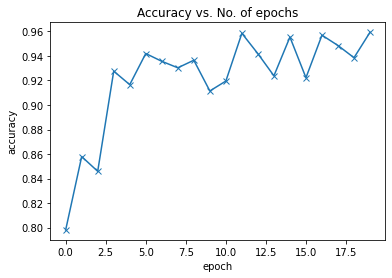

In [28]:
plot_accuracies(history)

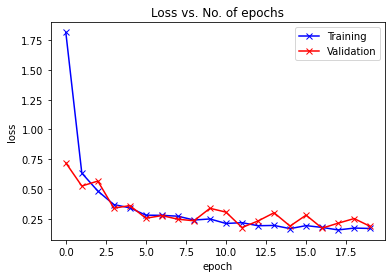

In [30]:
plot_losses(history)

# Model 1 with Early Stopping - History

---



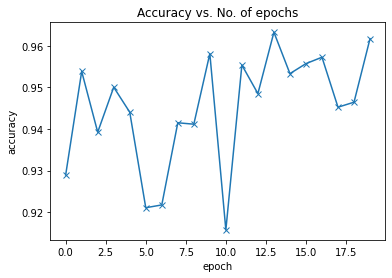

In [36]:
plot_accuracies(history_stop)

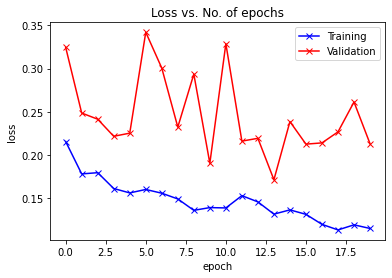

In [37]:
plot_losses(history_stop)

# Model 2 with Weight Decay - History

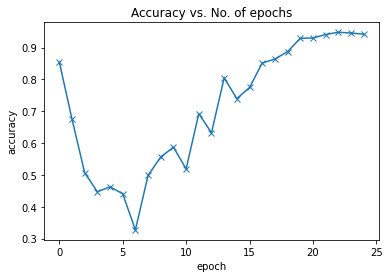

In [34]:
plot_accuracies(history_decay)

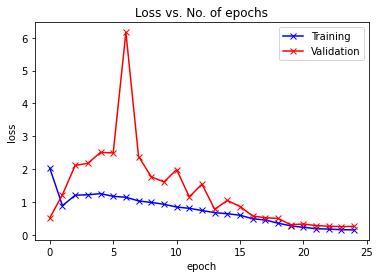

In [35]:
plot_losses(history_decay)

# Test Dataset Accuracy

In [38]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.17140242457389832, 'val_acc': 0.9509804248809814}

# **Flower Classification Model Training & Evaluation Results**

The model evaluation results:

- Validation Accuracy: 0.96

- Test Accuracy: 0.95

## Testing with individual images

In [39]:
def predict_image(img, model, dataset):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: 1 , Predicted: 1


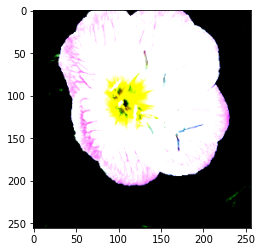

In [54]:
img, label = testing_imagefolder[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testing_imagefolder.classes[label], ', Predicted:', predict_image(img, model,testing_imagefolder))

Label: 26 , Predicted: 26


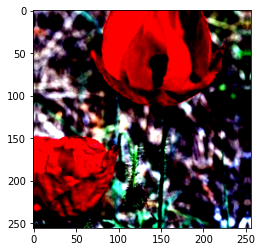

In [46]:
img, label = testing_imagefolder[110]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testing_imagefolder.classes[label], ', Predicted:', predict_image(img, model,testing_imagefolder))

Label: 98 , Predicted: 98


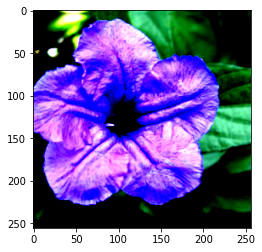

In [47]:
img, label = testing_imagefolder[810]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testing_imagefolder.classes[label], ', Predicted:', predict_image(img, model,testing_imagefolder))

## Saving and loading the model

In [44]:
torch.save(model.state_dict(), 'flower-resnet-finetuned.pth')

In [48]:
final_model = FlowersModel(len(training_imagefolder.classes)).to(device)

In [49]:
final_model.load_state_dict(torch.load('flower-resnet-finetuned.pth'))

<All keys matched successfully>

In [50]:
evaluate(final_model, test_loader)

{'val_loss': 0.17140242457389832, 'val_acc': 0.9509804248809814}

# **Wrap-up**

The final classification model is evaluated against a test dataset for sanity check to test how well it generalizes against unseen data. 

Final result: The model is able to classify all the unseen flower images correctly. The results can be further improve with hyperparameter tuning and more training. It is something for me to explore in future.

In summary, the model seemed to be able to perform well on a given small dataset.

# **Proposed Improvements**

Due to reasons such as time and resources constraints, the final model might not provide the best possible accuracy or optimal designs.

Few improvement suggestions are provided below in order to improve the model performance.

- Apply more Data Augmentation, i.e. random (but realistic) transformations such as flip, brightness and contrast etc. on the training dataset to increase its size and diversity.

- Adding Dropoutlayer and Batchnormalisation layers

- Optimize the learning rate, batch size and optimizer.

- Use weight and Biases analysis tools to track, analyze and optimize the performance of the model.